In [ ]:
#Source: https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html
#http://www.manythings.org/anki/

In [143]:
#Import all required libraries
import numpy as np
import pandas as pd
from keras.models import Model
from keras.layers import Input, Dense, LSTM
from keras.utils.vis_utils import plot_model

In [144]:
# configure variables
batch_size = 65
epochs = 100
latent_dim = 256
num_samples=10000

In [145]:
#File Info
file_name = 'fra.txt'
input_texts = []
target_texts = []
input_chars = set()
target_chars = set()

In [146]:
#Read from File and initialize variables
with open(file_name, 'r', encoding='utf-8') as f:
    all_lines = f.read().split('\n')
    for line in all_lines[:min(num_samples, len(all_lines)-1)]:
        input_text, target_text, _ = line.split('\t')
        input_texts.append(input_text)
        target_text = '\t'+target_text+'\n'
        target_texts.append(target_text)
        
        for ch in input_text:
            if ch not in input_chars:
                input_chars.add(ch)
                
        for ch in target_text:
            if ch not in target_chars:
                target_chars.add(ch)

In [147]:
#len(input_texts) #10000
len(target_texts) #10000

10000

In [148]:
#len(input_chars) #71
len(target_chars) #93

93

In [149]:
input_chars = sorted(list(input_chars))
target_chars = sorted(list(target_chars))

In [150]:
num_encoder_tokens = len(input_chars)
num_decoder_tokens = len(target_chars)
print(num_encoder_tokens,';',num_decoder_tokens)

71 ; 93


In [151]:
max_encoder_seq_length = max([len(text) for text in input_texts])
max_decoder_seq_length = max([len(text) for text in target_texts])
print(max_encoder_seq_length,';',max_decoder_seq_length)

15 ; 59


In [152]:
#input char to index
input_token_index = dict([(ch, i) for i,ch in enumerate(input_chars)])
#input_token_index

In [153]:
#input char to index
target_token_index = dict([(ch, i) for i,ch in enumerate(target_chars)])
#target_token_index
reverse_target_char_index = dict([(i, ch) for i,ch in enumerate(target_chars)])

In [154]:
len(input_texts)

10000

In [155]:
encoder_input_data = np.zeros((num_samples,max_encoder_seq_length,num_encoder_tokens), dtype='float32')
decoder_input_data = np.zeros((num_samples,max_decoder_seq_length,num_decoder_tokens), dtype='float32')
decoder_target_data = np.zeros((num_samples,max_decoder_seq_length,num_decoder_tokens), dtype='float32')

In [156]:
input_token_index[' ']

0

In [157]:
#char-wise One-hot-encoding of data
for i, (input_text,target_text) in enumerate(zip(input_texts, target_texts)):
    
    for j,char in enumerate(input_text):
        encoder_input_data[i, j, input_token_index[char]] = 1
    encoder_input_data[i, j+1:, input_token_index[' ']] = 1
    
    for k,char in enumerate(target_text):
        decoder_input_data[i, k, target_token_index[char]] = 1
        
        #target data is 1 ahead in time step
        if (k>0):
            decoder_target_data[i, k-1, target_token_index[char]] = 1
    decoder_input_data[i, k+1:, target_token_index[' ']] = 1
    decoder_target_data[i, k:, target_token_index[' ']] = 1

In [158]:
encoder_input_data.shape

(10000, 15, 71)

In [159]:
decoder_target_data.shape

(10000, 59, 93)

In [160]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

In [161]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [162]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
# plot the model
#plot_model(model, to_file='model.png', show_shapes=True)
model.compile(optimizer='rmsprop', loss = 'categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, None, 71)]   0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, None, 93)]   0                                            
__________________________________________________________________________________________________
lstm_6 (LSTM)                   [(None, 256), (None, 335872      input_9[0][0]                    
__________________________________________________________________________________________________
lstm_7 (LSTM)                   [(None, None, 256),  358400      input_10[0][0]                   
                                                                 lstm_6[0][1]         

In [ ]:
#fit model

In [89]:
model.fit([encoder_input_data, decoder_input_data], decoder_target_data, batch_size=batch_size, epochs=epochs,
         validation_split=0.2)

Epoch 1/100
124/124 [==============================] - 35s 285ms/step - loss: 1.1358 - accuracy: 0.7351 - val_loss: 1.0478 - val_accuracy: 0.7131
Epoch 2/100
124/124 [==============================] - 32s 261ms/step - loss: 0.8326 - accuracy: 0.7754 - val_loss: 0.8572 - val_accuracy: 0.7638
Epoch 3/100
124/124 [==============================] - 32s 260ms/step - loss: 0.6795 - accuracy: 0.8104 - val_loss: 0.7437 - val_accuracy: 0.7893
Epoch 4/100
124/124 [==============================] - 33s 268ms/step - loss: 0.5904 - accuracy: 0.8293 - val_loss: 0.6865 - val_accuracy: 0.7976
Epoch 5/100
124/124 [==============================] - 33s 263ms/step - loss: 0.5406 - accuracy: 0.8423 - val_loss: 0.6432 - val_accuracy: 0.8129
Epoch 6/100
124/124 [==============================] - 33s 268ms/step - loss: 0.5047 - accuracy: 0.8523 - val_loss: 0.6201 - val_accuracy: 0.8182
Epoch 7/100
124/124 [==============================] - 34s 278ms/step - loss: 0.4754 - accuracy: 0.8599 - val_loss: 0.5829 -

Epoch 57/100
124/124 [==============================] - 37s 298ms/step - loss: 0.1010 - accuracy: 0.9683 - val_loss: 0.5937 - val_accuracy: 0.8705
Epoch 58/100
124/124 [==============================] - 37s 299ms/step - loss: 0.0985 - accuracy: 0.9688 - val_loss: 0.5903 - val_accuracy: 0.8716
Epoch 59/100
124/124 [==============================] - 37s 295ms/step - loss: 0.0966 - accuracy: 0.9695 - val_loss: 0.6081 - val_accuracy: 0.8686
Epoch 60/100
124/124 [==============================] - 36s 292ms/step - loss: 0.0948 - accuracy: 0.9700 - val_loss: 0.6081 - val_accuracy: 0.8702
Epoch 61/100
124/124 [==============================] - 36s 286ms/step - loss: 0.0929 - accuracy: 0.9703 - val_loss: 0.6060 - val_accuracy: 0.8728
Epoch 62/100
124/124 [==============================] - 35s 286ms/step - loss: 0.0909 - accuracy: 0.9710 - val_loss: 0.6169 - val_accuracy: 0.8690
Epoch 63/100
124/124 [==============================] - 36s 291ms/step - loss: 0.0891 - accuracy: 0.9716 - val_loss: 0

In [91]:
import seaborn as sns
from matplotlib import pyplot as plt

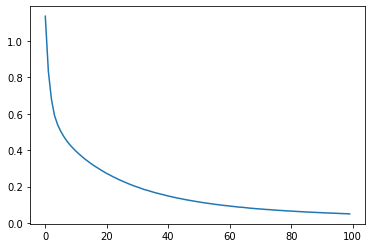

In [95]:
plt.plot(model.history.history['loss'])

In [96]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model([decoder_inputs] + decoder_states_inputs,[decoder_outputs] + decoder_states)

In [165]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [166]:
decoded_sentence = ''
def decode_sequence1(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    
    output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
    
    # Sample a token
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    print(sampled_token_index, ':', reverse_target_char_index[sampled_token_index])
        
    return decoded_sentence

In [168]:
for seq_index in range(100):
    input_seq = encoder_input_data[seq_index : seq_index+1]
    decoded_sentence = decode_sequence(input_seq)
    print('----')
    print('Input setence:', input_texts[seq_index])
    print('Decoded setence:', decoded_sentence)

----
Input setence: Go.
Decoded setence: Bouge !

----
Input setence: Go.
Decoded setence: Bouge !

----
Input setence: Go.
Decoded setence: Bouge !

----
Input setence: Hi.
Decoded setence: Salut.

----
Input setence: Hi.
Decoded setence: Salut.

----
Input setence: Run!
Decoded setence: File !

----
Input setence: Run!
Decoded setence: File !

----
Input setence: Run!
Decoded setence: File !

----
Input setence: Run!
Decoded setence: File !

----
Input setence: Run!
Decoded setence: File !

----
Input setence: Run!
Decoded setence: File !

----
Input setence: Run!
Decoded setence: File !

----
Input setence: Run!
Decoded setence: File !

----
Input setence: Run.
Decoded setence: Fuyons !

----
Input setence: Run.
Decoded setence: Fuyons !

----
Input setence: Run.
Decoded setence: Fuyons !

----
Input setence: Run.
Decoded setence: Fuyons !

----
Input setence: Run.
Decoded setence: Fuyons !

----
Input setence: Run.
Decoded setence: Fuyons !

----
Input setence: Run.
Decoded setence

In [ ]:
#DONE